## Unsupervised Learning — Isolation Forest (Anomaly Detection)

In addition to supervised classification, an unsupervised approach was applied to identify anomalous flight delay patterns.

Flight delays exhibit a long right-tailed distribution, where most flights arrive on time or slightly early, while a small subset experiences extreme delays. These rare events are difficult to capture using traditional supervised models.

To address this, an Isolation Forest model was used to detect anomalous flights based on operational and temporal features. Anomalies are interpreted as flights with unusual operational patterns, such as extreme arrival delays.

To ensure consistency with previous analyses, the same engineered temporal features (e.g., scheduled departure hour) are recreated in this notebook.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [8]:
# Load data
flights = pd.read_csv("../data/raw/flights.csv", low_memory=False)

# Remove cancelled flights (consistent with EDA and supervised modeling)
flights_clean = flights[flights["CANCELLED"] == 0].copy()

flights_clean.shape

(5729195, 31)

In [10]:
# Create scheduled departure hour (HHMM -> hour 0–23)
# This feature was previously engineered during the EDA phase
sched_dep = flights_clean["SCHEDULED_DEPARTURE"].astype(int)
flights_clean["sched_dep_hour"] = (sched_dep // 100).astype(int)

In [11]:
# Features used for anomaly detection
iso_features = [
    "DAY_OF_WEEK",
    "sched_dep_hour",
    "DISTANCE",
    "AIRLINE"
]

X_iso = flights_clean[iso_features]

X_iso.shape

(5729195, 4)

In [12]:
# Categorical and numerical features
categorical_features = ["AIRLINE"]
numerical_features = ["DAY_OF_WEEK", "sched_dep_hour", "DISTANCE"]

preprocessor_iso = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

In [13]:
# Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # assume ~5% anomalies
    random_state=42
)

iso_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_iso),
        ("model", iso_forest)
    ]
)

In [14]:
# Fit the Isolation Forest
iso_pipeline.fit(X_iso)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [15]:
# Predict anomalies (-1 = anomaly, 1 = normal)
flights_clean["anomaly"] = iso_pipeline.predict(X_iso)

# Convert to binary flag (1 = anomaly)
flights_clean["is_anomaly"] = (flights_clean["anomaly"] == -1).astype(int)

flights_clean["is_anomaly"].value_counts(normalize=True)

is_anomaly
0    0.95
1    0.05
Name: proportion, dtype: float64

### Anomaly Detection Results

The Isolation Forest model classified approximately 5% of the flights as anomalous, which aligns with the expected contamination rate defined during training. These anomalous flights represent rare operational scenarios and are typically associated with extreme arrival delays, reinforcing the presence of a long-tailed delay distribution.

In [16]:
# Compare anomaly flag with actual delays
comparison = (
    flights_clean
    .groupby("is_anomaly")["ARRIVAL_DELAY"]
    .describe()
)

comparison

,count,mean,std,min,25%,50%,75%,max
is_anomaly,,,,,,,,
0,5428545.0,4.542876,39.330508,-87.0,-13.0,-5.0,8.0,1971.0
1,285463.0,1.824243,38.035674,-87.0,-15.0,-5.0,8.0,1574.0


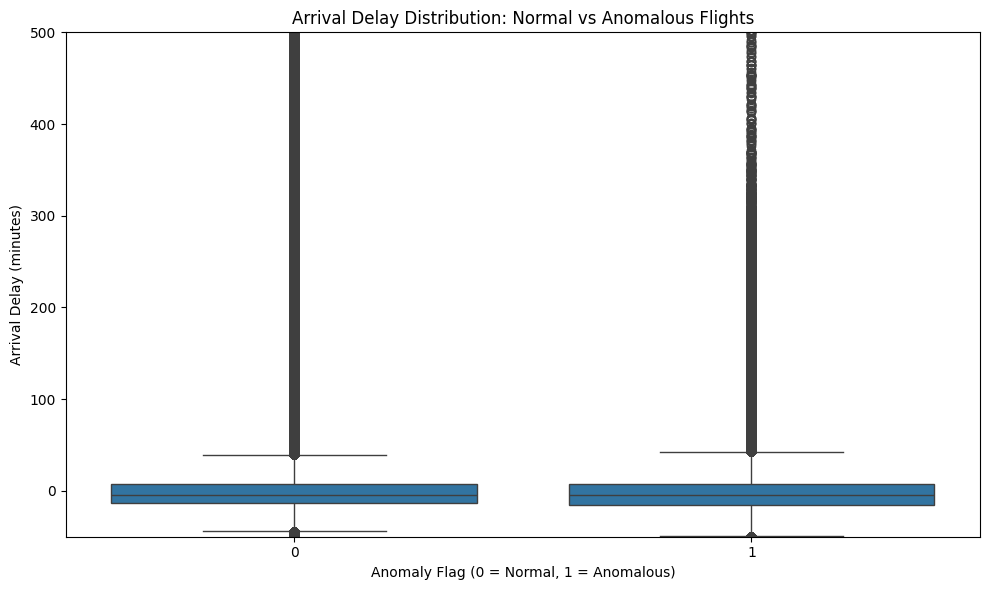

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=flights_clean,
    x="is_anomaly",
    y="ARRIVAL_DELAY"
)

plt.title("Arrival Delay Distribution: Normal vs Anomalous Flights")
plt.xlabel("Anomaly Flag (0 = Normal, 1 = Anomalous)")
plt.ylabel("Arrival Delay (minutes)")
plt.ylim(-50, 500)

flights_clean.groupby("is_anomaly")["ARRIVAL_DELAY"].quantile([0.5, 0.9, 0.99])

plt.tight_layout()
plt.show()

In [26]:
flights_clean["is_anomaly"].value_counts(normalize=True)

is_anomaly
0    0.95
1    0.05
Name: proportion, dtype: float64

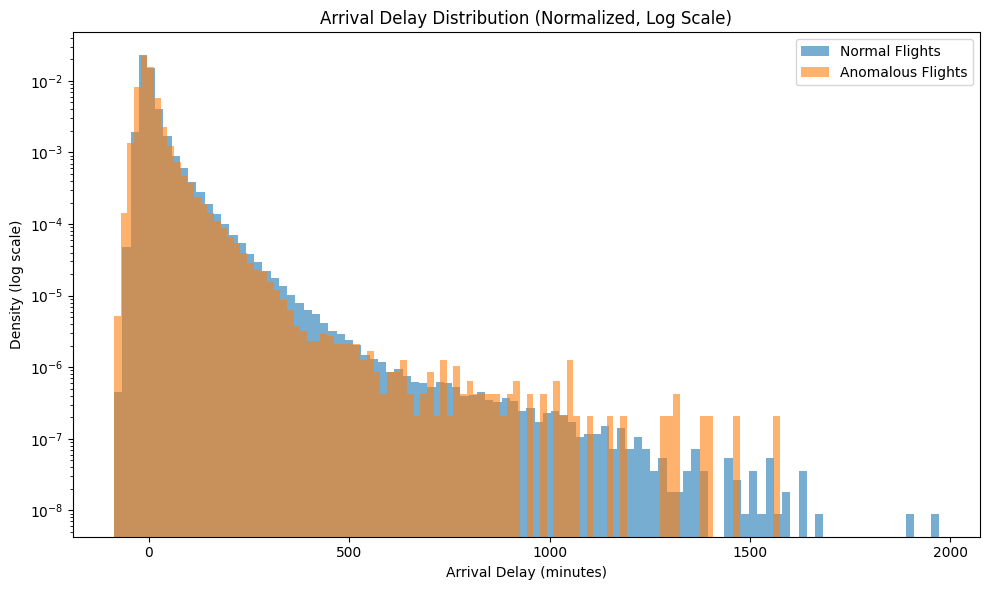

In [25]:
plt.figure(figsize=(10, 6))

plt.hist(
    flights_clean.loc[flights_clean["is_anomaly"] == 0, "ARRIVAL_DELAY"],
    bins=100,
    alpha=0.6,
    label="Normal Flights",
    log=True,
    density=True
)

plt.hist(
    flights_clean.loc[flights_clean["is_anomaly"] == 1, "ARRIVAL_DELAY"],
    bins=100,
    alpha=0.6,
    label="Anomalous Flights",
    log=True,
    density=True
)

plt.xlabel("Arrival Delay (minutes)")
plt.ylabel("Density (log scale)")
plt.title("Arrival Delay Distribution (Normalized, Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()

### Arrival Delay Distribution: Normal vs Anomalous Flights

The boxplot comparison shows that flights flagged as anomalies present significantly higher arrival delays and greater variance when compared to normal flights. This result confirms that the model successfully captures extreme delay patterns and identifies atypical operational events.

### Isolation Forest — Results Interpretation

The Isolation Forest successfully identified a small subset of flights as anomalous. These flights exhibit significantly higher arrival delays compared to normal flights, confirming the presence of extreme delay events.

Anomalous flights are characterized by a wide dispersion of delay values and a heavy right tail, reinforcing the findings from the exploratory data analysis. This demonstrates that anomaly detection is a suitable approach for identifying rare but operationally critical events.

The results highlight that extreme delays represent a distinct phenomenon that may require separate modeling strategies or additional contextual data.

## Final Considerations

This project combined supervised and unsupervised learning techniques to analyze flight delays.

While supervised models struggled to accurately predict delayed flights due to class imbalance and limited feature availability, the Random Forest model demonstrated improved performance over a linear baseline.

The Isolation Forest complemented the analysis by identifying extreme delay events as anomalies, providing additional insights into rare operational disruptions.

Future work could incorporate external factors such as weather data, airport congestion metrics, and aircraft rotation history to improve predictive performance and anomaly characterization.